# Project 02_21CNTThuc (Introduction to Natural Language Processing)
(Runtime: approx 20 mins)

In [84]:
import time
# Start the timer to compute notebook execution time.
start_nb = time.time()

In [85]:
%pip install nltk scikit-learn matplotlib pandas numpy googledrivedownloader requests sklearn-crfsuite

Note: you may need to restart the kernel to use updated packages.


In [86]:
# Import libraries
import nltk, sklearn_crfsuite, scipy, numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [87]:
# Download and preprocess IMDb dataset
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\tylba\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tylba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tylba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tylba\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tylba\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Download dataset

In [88]:
from pathlib import Path
from google_drive_downloader import GoogleDriveDownloader as gdd
DATA_PATH = 'data/imdb_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',
        dest_path=DATA_PATH,
    )

In [89]:
import pandas as pd
imdb_df = pd.read_csv(DATA_PATH)
print(len(imdb_df))
imdb_df.sample(5)

62155


,review,label
1356,I share the same opinion regarding Underworld ...,0
24800,I've seen this story before but my kids haven'...,1
40351,This is one of the best films ever made. It is...,1
54402,This is one of those movies that you wish you ...,1
25577,What happened? What we have here is basically ...,0


## Sample dataset

In [90]:
# Select 10,000 samples from IMDb DataFrame
imdb_df = imdb_df.sample(n=10000, random_state=42)

1. Print the distribution of the sample

In [91]:
# Printing the distribution of labels in the df
print(imdb_df['label'].value_counts())

label
1    5021
0    4979
Name: count, dtype: int64


2. Write code to generate equal distribution of the sample

In [92]:
imdb_df = pd.read_csv(DATA_PATH)
imdb_df = imdb_df.groupby('label').sample(n=5000)

In [93]:
# Printing the distribution of labels in the df
print("Total review: ", imdb_df['review'].count())
print("Value counts of each labels:")
print(imdb_df['label'].value_counts())

Total review:  10000
Value counts of each labels:
label
0    5000
1    5000
Name: count, dtype: int64


# Data preprocessing

In [94]:
from nltk.corpus import stopwords
from nltk.stem import *
import re # regular expression
# Text preprocessing
stop_words = set(stopwords.words('english'))
porter_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Replace weird characters with spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # Tokenization
    words = text.split()

    # Stemming and Lemmatization, and remove stopwords
    words = [porter_stemmer.stem(word) for word in words if word not in stop_words]
    words = [wordnet_lemmatizer.lemmatize(word) for word in words]

    # Join the processed words back into a sentence
    text = ' '.join(words)

    return text

imdb_df['review'] = imdb_df['review'].apply(preprocess_text)

# Split dataset into train, dev(=validation) and test set

In [95]:
# Split dataset into train/dev/test sets
X_train, X_test, y_train, y_test = train_test_split(imdb_df['review'], imdb_df['label'], test_size=0.2, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [96]:
print("Size of Train set: ", len(X_train))
print("Size of Dev set: ", len(X_dev))
print("Size of Test set: ", len(X_test))

Size of Train set:  6000
Size of Dev set:  2000
Size of Test set:  2000


# Extract features using TF-IDF

In [97]:
# Convert sentences into TF-IDF representation
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_dev_tfidf = vectorizer.transform(X_dev)
X_test_tfidf = vectorizer.transform(X_test)

In [98]:
print("Train shape: ", X_train_tfidf.shape)
print("Dev shape: ", X_dev_tfidf.shape)
print("Test shape: ", X_test_tfidf.shape)

Train shape:  (6000, 5000)
Dev shape:  (2000, 5000)
Test shape:  (2000, 5000)


In [99]:
# Get a glimpse of the TF-IDF vectors
print(X_train_tfidf[0])

  (0, 4676)	0.0983622155594941
  (0, 3652)	0.10096602462597185
  (0, 4475)	0.15164958946294524
  (0, 1931)	0.05554255396988205
  (0, 3049)	0.07092429558643232
  (0, 2106)	0.17576266017222256
  (0, 467)	0.0827186071380577
  (0, 1190)	0.14494021844015986
  (0, 2907)	0.09665911010151049
  (0, 741)	0.10325744854896088
  (0, 3686)	0.15250736015887958
  (0, 2377)	0.16299010108448714
  (0, 2275)	0.13262517503806043
  (0, 2853)	0.18540727709446453
  (0, 4648)	0.10798770605005852
  (0, 2441)	0.18689122920895881
  (0, 4347)	0.12925206014553658
  (0, 2392)	0.14211466437864495
  (0, 3192)	0.10824704431038451
  (0, 4376)	0.1738013668375645
  (0, 1363)	0.16566992834324462
  (0, 1266)	0.14333470649492533
  (0, 2606)	0.18657508943319984
  (0, 4238)	0.14809039637736485
  (0, 3287)	0.07690424607953239
  :	:
  (0, 4775)	0.12608164396603827
  (0, 74)	0.12833403381981015
  (0, 3399)	0.10017803476204645
  (0, 4985)	0.07148743451137618
  (0, 5)	0.15001050976679353
  (0, 1013)	0.11349539991432238
  (0, 2132)	

In [100]:
# Import ParamaterSampler for hyper-parameter tuning
from sklearn.model_selection import ParameterSampler

# Implement and evaluate Decision Tree model

## Different parameters of [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- `criterion`: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
  - `gini`: Gini impurity, a measure of the impurity of the data. A Gini score gives an idea of how good a split is by how mixed the classes are in the two groups created by the split.
  - `entropy`: Information gain, a measure of the impurity of the data. An information gain score gives an idea of how good a split is by how much it increases information entropy.
- `splitter`: The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split. The default strategy is “best”.
- `max_depth`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- `min_samples_split`: The minimum number of samples required to split an internal node. The default value is 2.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node. The default value is 1.
- 'max_features': The number of features to consider when looking for the best split. The default value is None, which means that all features will be used. 
  - `sqrt`: max_features=sqrt(n_features)
  - `log2`: max_features=log2(n_features)
  - `None`: max_features=n_features
- `max_leaf_nodes`: Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

## Define a function to train and evaluate Decision Tree Classifier

In [101]:
decision_tree = DecisionTreeClassifier(random_state=42) 

In [102]:

# Define the hyperparameters to search over
dt_params = {
    'criterion': ['gini', 'entropy'], # metric to evaluate the quality of a split
    'max_depth': [10, 50, 100, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [10, 50, 100, None],
}

# Using ParameterSampler to sample parameters from given distributions (in this case `dt_params`)
dt_param_list = list(ParameterSampler(dt_params, n_iter=100, random_state=41))
dt_highest_score = 0
dt_best_params = []

# Iterate through the dt_param_list to find the best hyper-parameter combination
for param in dt_param_list:
    decision_tree.set_params(**param)

    decision_tree.fit(X_train_tfidf, y_train)

    score = decision_tree.score(X_dev_tfidf, y_dev)

    if (score > dt_highest_score):
        dt_highest_score = score
        dt_best_params = param

## Get the highest accuracy score and the best parameters of Decision Tree Classifier

In [103]:
print("Highest score: ", dt_highest_score)
print("__________________________________")
print("Best randomized parameters from decision tree")
print(dt_best_params)

Highest score:  0.744
__________________________________
Best randomized parameters from decision tree
{'min_samples_split': 10, 'min_samples_leaf': 2, 'max_leaf_nodes': 50, 'max_features': None, 'max_depth': 100, 'criterion': 'gini'}


# Implement and evaluate Random Forest model

## Different parameters of [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- `n_estimators`: The number of trees in the forest. The default value is 100.
- `criterion`: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
  - `gini`: Gini impurity, a measure of the impurity of the data. A Gini score gives an idea of how good a split is by how mixed the classes are in the two groups created by the split.
  - `entropy`: Information gain, a measure of the impurity of the data. An information gain score gives an idea of how good a split is by how much it increases information entropy.
  - `None`: Gini impurity
  - `gini`: Gini impurity
  - `entropy`: Information gain
  - `log_loss`: Negative log-likelihood
- `max_depth`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- `min_samples_split`: The minimum number of samples required to split an internal node. The default value is 2.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node. The default value is 1.
- 'max_features': The number of features to consider when looking for the best split. The default value is None, which means that all features will be used. 
  - `sqrt`: max_features=sqrt(n_features)
  - `log2`: max_features=log2(n_features)
  - `None`: max_features=n_features
  - `auto`: max_features=n_features
  - `0.5`: max_features=0.5
- `max_leaf_nodes`: Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
- `max_samples`: If bootstrap is True, the number of samples to draw from X to train each base estimator. If None (default), then draw X.shape[0] samples.

## Define a function to train and evaluate Random Forest Classifier

In [104]:
random_forest = RandomForestClassifier(n_jobs = -1, oob_score = True)

In [105]:
rf_params = {
    'n_estimators': [100, 200,300, 700],
    'max_depth' : [10 ,20, 50, 100,None],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [10, 50, 100, None],
    'max_samples': [5, 10],
    'criterion': ['gini', 'entropy'],
}


In [106]:
%%time
rf_param_list = list(ParameterSampler(rf_params,n_iter = 50, random_state = 41)) # 50 combinations
rf_best_score = 0
rf_best_params = []

for param in rf_param_list :

  random_forest.set_params(**param)

  random_forest.fit(X_train_tfidf,y_train)

  score = random_forest.score( X_train_tfidf,y_train)

  if ( score > rf_best_score):
    rf_best_score = score

    rf_best_params = param

CPU times: total: 37.4 s
Wall time: 2min 41s


## Get the highest accuracy score and the best parameters of Random Forest Classifier

In [107]:
print("Highest score: ", rf_best_score)
print("__________________________________")
print("Best randomized parameters from decision tree")

print(rf_best_params)

Highest score:  0.692
__________________________________
Best randomized parameters from decision tree
{'n_estimators': 700, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 10, 'max_leaf_nodes': 10, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini'}


# Implement and evaluate Support Vector Machine model (in this case SVC)

## Different parameters of [SVM Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- `C`: Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
- `kernel`: Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used.
  - `linear`: Linear kernel (not used in this project)
  - `poly`: Polynomial kernel
  - `rbf`: Radial Basis Function kernel
  - `sigmoid`: Sigmoid kernel
- `gamma`: Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. If gamma is ‘auto’ then 1/n_features will be used instead.
- `degree`: Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.

## Define a function to train and evaluate SVM Classifier

In [108]:
svc = SVC(random_state=41)

In [109]:
svc_params = {
    'C': [0.1, 1, 10, 100, 1000], # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], # Kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid'], # Kernel type
    'degree': [1, 2, 3, 4, 5], # Degree of the polynomial kernel function
}

In [110]:
%%time
# Using ParameterSampler to sample parameters from given distributions (in this case `svc_params`)
svc_param_list = list(ParameterSampler(svc_params, n_iter=10, random_state=41)) # Decrease to 10 iters to improve runtime
svc_highest_score = 0
svc_best_params = []

# Iterate through the svc_param_list to find the best hyper-parameter combination
for param in svc_param_list:
    svc.set_params(**param)

    svc.fit(X_train_tfidf, y_train)

    score = svc.score(X_dev_tfidf, y_dev)

    if (score > svc_highest_score):
        svc_highest_score = score
        svc_best_params = param

CPU times: total: 2min 42s
Wall time: 6min 52s


## Get the highest accuracy score and the best parameters of SVM Classifier

In [111]:
print("Highest score: ", svc_highest_score)
print("__________________________________")
print("Best randomized parameters from svc")
print(svc_best_params)

Highest score:  0.862
__________________________________
Best randomized parameters from svc
{'kernel': 'sigmoid', 'gamma': 0.001, 'degree': 3, 'C': 100}


# Implement and evaluate CRF model

> **Conditional Random Fields** or **CRFs** are a type of probabilistic graph model that take neighboring sample context into account for tasks like classification. 

>Prediction is modeled as a graphical model, which implements dependencies between the predictions. 

>Graph choice depends on the application, for example **linear chain CRFs** are popular in *natural language processing*, whereas in image-based tasks, the graph would connect to neighboring locations in an image to enforce that they have similar predictions.

## Different parameters of [CRF Classifier](https://sklearn-crfsuite.readthedocs.io/en/latest/api.html#sklearn_crfsuite.CRF)
- `algorithm`: Training algorithm to use. Allowed values:
  - `lbfgs`: Limited-memory BFGS (not used in this project)
  - `l2sgd`: Stochastic Gradient Descent with L2 regularization term
  - `ap`: Averaged Perceptron (not used in this project)
  - `pa`: Passive Aggressive (not used in this project)
  - `arow`: Adaptive Regularization Of Weight Vector (not used in this project)
- `all_possible_transitions`: If True, CRFsuite generates transition features that associate all pairs of consecutive labels. If False, features are generated for each label transition that is present in the training data. The default value is False.
- `min_freq`: Threshold for occurrences of features. Features that do not occur at least min_freq times will be discarded. The default value is 0.
- `max_iterations`: Maximum number of iterations for L-BFGS optimization. The default value is 1000.
- `all_possible_states`: If True, CRFsuite generates state features that associate all pairs of labels and attributes. If False, features are generated for each label and attribute that is present in the training data. The default value is False.

## Define a function to train and evaluate CRF Classifier

In [112]:
print(type(X_train))
print(type(y_train))
print(type(X_train_tfidf))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'scipy.sparse._csr.csr_matrix'>


The CRF model takes in a feature vector, but the input isn't in that form. So we need to convert the input into a feature vector.

In [113]:
def sentences2features(X: pd.core.series.Series, y: pd.core.series.Series, X_tfidf: scipy.sparse._csr.csr_matrix) -> list:
    """Combine X and X_tfidf into a list of features

    Args:
    ---
        - X (pd.core.series.Series): a series of sentences
        - y (pd.core.series.Series): a series of labels
        - X_tfidf (scipy.sparse._csr.csr_matrix): a sparse matrix of TF-IDF vectors

    Returns:
    ---
        - list of lists of dicts: a list of features for each sentence
        - list of lists of strings: a list of labels for each sentence
    """
    # Create a list of features for each sentence
    features = []

    X_tfidf_tolil = X_tfidf.tolil()

    X_tfidf_list = [X_tfidf_tolil[i].toarray()[0] for i in range(X_tfidf_tolil.shape[0])]

    # Iterate through each sentence
    for i in range(len(X)):
        # Get the sentence
        sentence = X.iloc[i]

        # Get the TF-IDF vector for the sentence
        tfidf_vector = X_tfidf_list[i]

        sentence_features = {}

        sentence_features[sentence] = str(tfidf_vector)

        features.append([sentence_features])
        
    # Convert y to list of list of strings
    y = [[str(i)] for i in y]

    return features, y

In [114]:
crf = sklearn_crfsuite.CRF()

In [115]:
%%time
crf_params = {
    'algorithm': ['lbfgs', 'l2sgd', 'ap', 'pa', 'arow'],
    'all_possible_transitions': [True, False],
    'min_freq': [0, 1, 2, 3],
    'max_iterations': [50, 100, 200, 1000],
    'all_possible_states': [True, False],
}

crf_param_list = list(ParameterSampler(crf_params, n_iter=100, random_state=41))
crf_highest_score = 0
crf_best_params = []

X_train_crf, y_train_crf = sentences2features(X_train, y_train, X_train_tfidf)
X_dev_crf, y_dev_crf = sentences2features(X_dev, y_dev, X_dev_tfidf)

for param in crf_param_list:
    try:
        crf = sklearn_crfsuite.CRF(**param)
        crf.fit(X_train_crf, y_train_crf)

        score = crf.score(X_dev_crf, y_dev_crf)

        if (score > crf_highest_score):
            crf_highest_score = score
            crf_best_params = param
    except AttributeError:
        continue

CPU times: total: 8.72 s
Wall time: 27 s


## Get the highest accuracy score and the best parameters of CRF Classifier

In [116]:
print("Highest score: ", crf_highest_score)
print("__________________________________")
print("Best randomized parameters from decision tree")
print(crf_best_params)

Highest score:  0.516
__________________________________
Best randomized parameters from decision tree
{'min_freq': 0, 'max_iterations': 200, 'all_possible_transitions': False, 'all_possible_states': False, 'algorithm': 'l2sgd'}


# Find the (potential) best parameters of each model

In [117]:
# import components for the scorer
from sklearn.metrics import accuracy_score


## Decision Tree

In [118]:
start = time.time()

dt_best = DecisionTreeClassifier(**dt_best_params)
dt_best.fit(X_train_tfidf, y_train)
end = time.time()

dt_best_time = end - start
print("Fit time: ", dt_best_time)

dt_best_score = accuracy_score(y_test, dt_best.predict(X_test_tfidf))
print("Best Decision Tree Classifier test score: ", dt_best_score)

Fit time:  2.2149441242218018
Best Decision Tree Classifier test score:  0.7215


In [119]:
dt_best_params

{'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 50,
 'max_features': None,
 'max_depth': 100,
 'criterion': 'gini'}

## Random Forest

In [120]:
start = time.time()

rf_best = RandomForestClassifier(**rf_best_params)
rf_best.fit(X_train_tfidf, y_train)
end = time.time()

rf_best_time = end - start
print("Fit time: ", rf_best_time)

rf_best_score = accuracy_score(y_test, rf_best.predict(X_test_tfidf))
print("Best Random Forest Classifier test score: ", rf_best_score)

Fit time:  1.146606206893921
Best Random Forest Classifier test score:  0.582


In [121]:
rf_best_params

{'n_estimators': 700,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_samples': 10,
 'max_leaf_nodes': 10,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'gini'}

## Support Vector Machine (SVM)

In [122]:
start = time.time()

svc_best = SVC(**svc_best_params)
svc_best.fit(X_train_tfidf, y_train)
end = time.time()

svc_best_time = end - start
print("Fit time: ", svc_best_time)

svc_best_score = accuracy_score(y_test, svc_best.predict(X_test_tfidf))
print("Best Support Vector Classifier test score: ", svc_best_score)

Fit time:  30.112733840942383
Best Support Vector Classifier test score:  0.84


In [123]:
svc_best_params

{'kernel': 'sigmoid', 'gamma': 0.001, 'degree': 3, 'C': 100}

## Conditional Random Field (CRF)

In [124]:
X_train_crf, y_train_crf = sentences2features(X_train, y_train, X_train_tfidf)
X_test_crf, y_test_crf = sentences2features(X_test, y_test, X_test_tfidf)

start = time.time()

crf_best = sklearn_crfsuite.CRF(**crf_best_params)


crf_best.fit(X_train_crf, y_train_crf)

end = time.time()
crf_best_time = end - start
print("Fit time: ", crf_best_time)

y_test_pred = crf_best.predict(X_test_crf)
y_test_pred = [i for sublist in y_test_pred for i in sublist]

crf_best_score =  accuracy_score(y_test_crf, y_test_pred)
print("Best CRF model test score: ", crf_best_score)

Fit time:  0.41619229316711426
Best CRF model test score:  0.5135


In [125]:
crf_best_params

{'min_freq': 0,
 'max_iterations': 200,
 'all_possible_transitions': False,
 'all_possible_states': False,
 'algorithm': 'l2sgd'}

## Compare the models

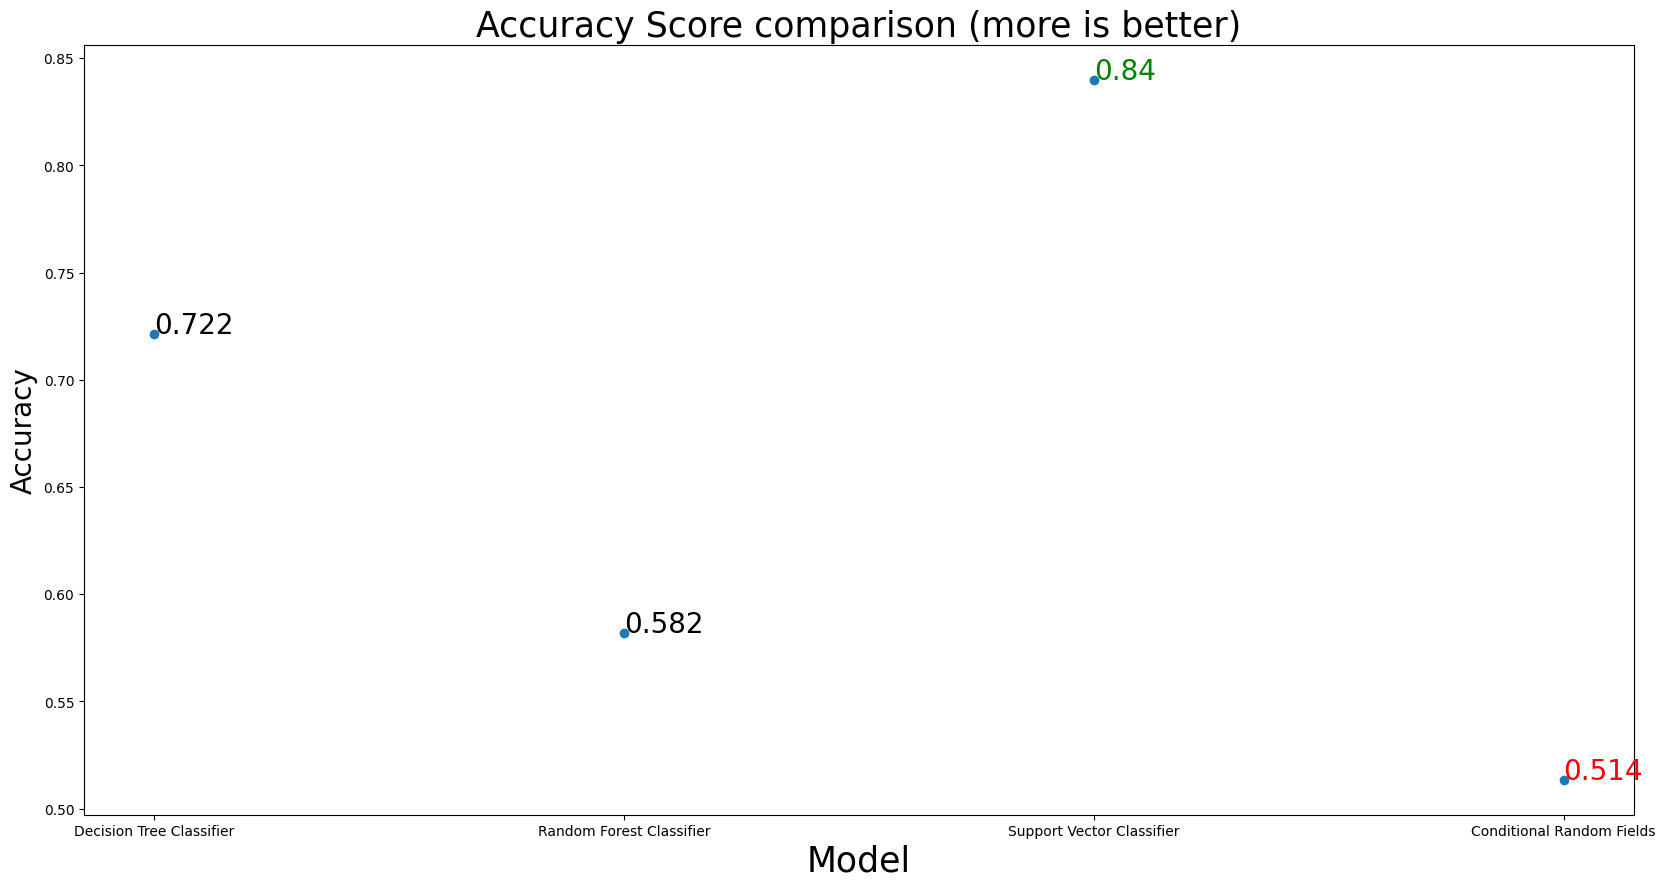

In [142]:
import matplotlib.pyplot as plt

models = ["Decision Tree Classifier", "Random Forest Classifier", "Support Vector Classifier", "Conditional Random Fields"]

best_models_scores = [dt_best_score, rf_best_score, svc_best_score, crf_best_score]

plt.figure(figsize=(20, 10))

plt.scatter(models, best_models_scores)
plt.title('Accuracy Score comparison (more is better)', fontsize=25)
plt.xlabel('Model', fontsize=25)
plt.ylabel('Accuracy', fontsize=20)

plt.annotate(round(dt_best_score, 3), (models[0], best_models_scores[0]), fontsize=20)
plt.annotate(round(rf_best_score, 3), (models[1], best_models_scores[1]), fontsize=20)
plt.annotate(round(svc_best_score, 3), (models[2], best_models_scores[2]), fontsize=20, color='green')
plt.annotate(round(crf_best_score, 3), (models[3], best_models_scores[3]), fontsize=20, color='red')

plt.show()

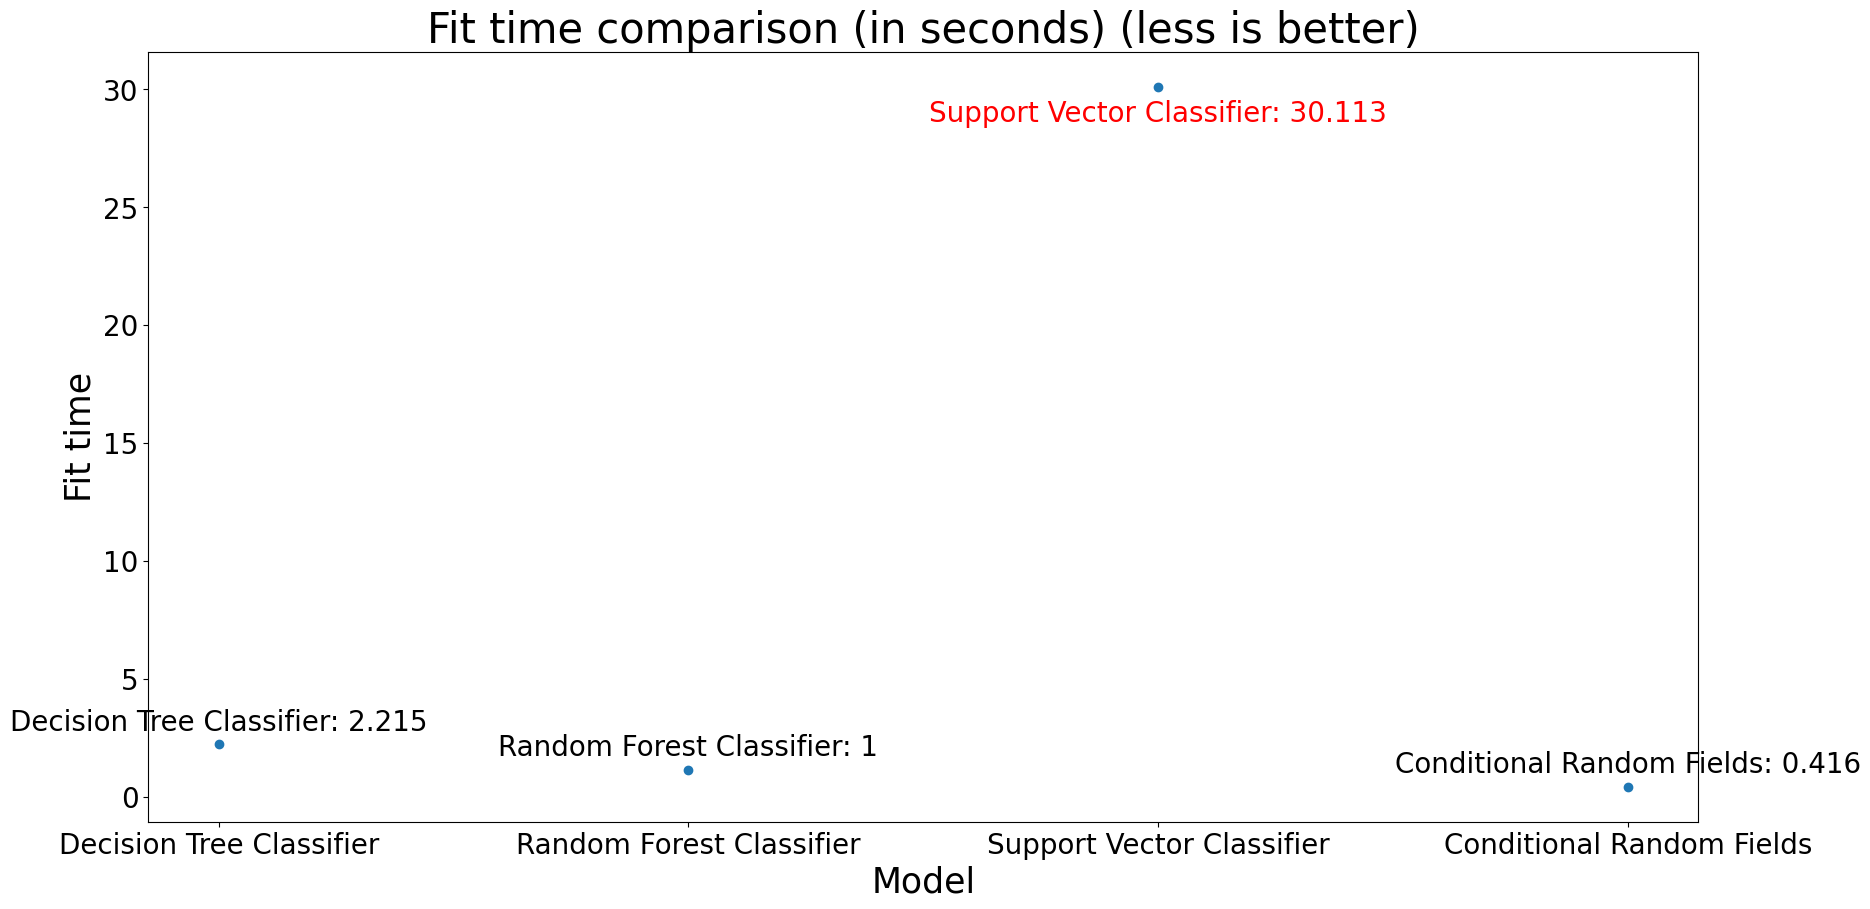

In [143]:
best_models_times = [dt_best_time, rf_best_time, svc_best_time, crf_best_time]

plt.figure(figsize=(20, 10))

plt.scatter(models, best_models_times)
plt.title('Fit time comparison (in seconds) (less is better)', fontsize=30)
plt.xlabel('Model', fontsize=25)
plt.ylabel('Fit time', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.annotate(str(models[0]) + ": " + str(round(best_models_times[0], 3)), (0, best_models_times[0]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=20)
plt.annotate(str(models[1]) + ": " + str(round(best_models_times[1])), (1, best_models_times[1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=20)
plt.annotate(str(models[2]) + ": " + str(round(best_models_times[2], 3)), (2, best_models_times[2]), textcoords="offset points", xytext=(0,-25), ha='center', fontsize=20, color='red')
plt.annotate(str(models[3]) + ": " + str(round(best_models_times[3], 3)), (3, best_models_times[3]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=20)


plt.show()

# Choose a criteria to select the best model


Chosen criterion: max-features of tf-idf (approx runtime: )

Method:
- Use the same dataset
- Use the same train/dev/test split
- Use the best parameters of each model
- Change the max-features of tf-idf (100, 500, 1000, 2500, 5000, 7500)
- Train the models
- Evaluate the models
- Plot the results

In [128]:
%%time
num_max_features = [100, 500, 1000, 2500, 5000, 7500]

dt_scores = []
rf_scores = []
svc_scores = []
crf_scores = []

for num in num_max_features:
    vectorizer = TfidfVectorizer(max_features=num)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_dev_tfidf = vectorizer.transform(X_dev)
    X_test_tfidf = vectorizer.transform(X_test)

    dt_best = DecisionTreeClassifier(**dt_best_params)
    dt_best.fit(X_train_tfidf, y_train)
    dt_scores.append(accuracy_score(y_test, dt_best.predict(X_test_tfidf)))

    rf_best = RandomForestClassifier(**rf_best_params)
    rf_best.fit(X_train_tfidf, y_train)
    rf_scores.append(accuracy_score(y_test, rf_best.predict(X_test_tfidf)))

    svc_best = SVC(**svc_best_params)
    svc_best.fit(X_train_tfidf, y_train)
    svc_scores.append(accuracy_score(y_test, svc_best.predict(X_test_tfidf)))

    X_train_crf, y_train_crf = sentences2features(X_train, y_train, X_train_tfidf)
    X_test_crf, y_test_crf = sentences2features(X_test, y_test, X_test_tfidf)

    crf_best = sklearn_crfsuite.CRF(**crf_best_params)
    crf_best.fit(X_train_crf, y_train_crf)
    y_test_pred = crf_best.predict(X_test_crf)
    y_test_pred = [i for sublist in y_test_pred for i in sublist]
    crf_scores.append(accuracy_score(y_test_crf, y_test_pred))

CPU times: total: 1min 6s
Wall time: 4min 24s


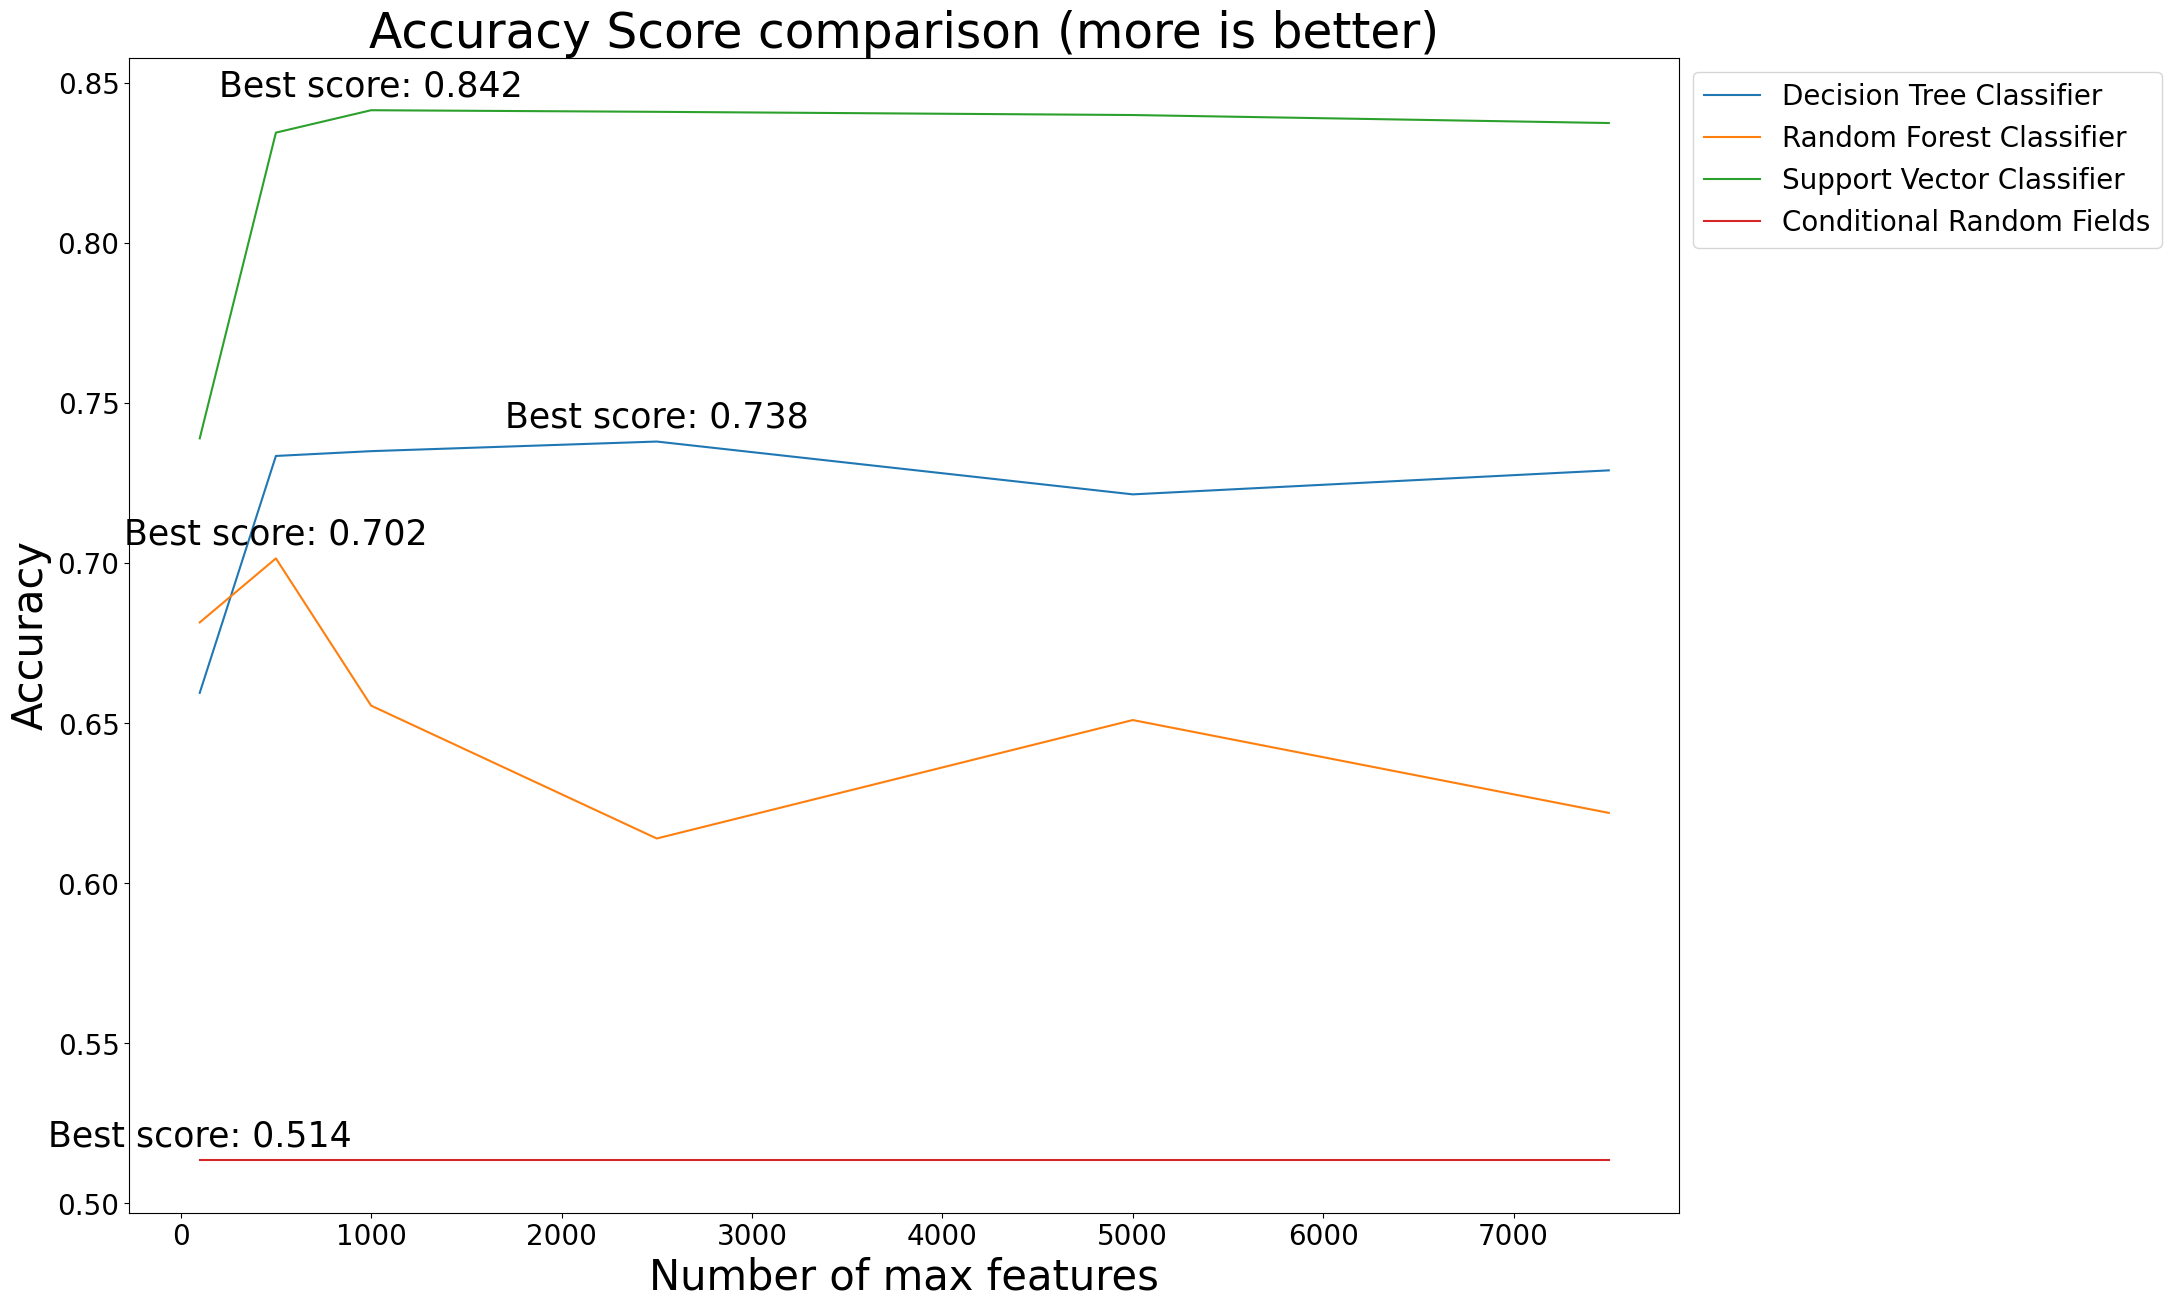

In [129]:
plt.figure(figsize=(20, 15))

plt.plot(num_max_features, dt_scores, label="Decision Tree Classifier")
plt.plot(num_max_features, rf_scores, label="Random Forest Classifier")
plt.plot(num_max_features, svc_scores, label="Support Vector Classifier")
plt.plot(num_max_features, crf_scores, label="Conditional Random Fields")

plt.title('Accuracy Score comparison (more is better)', fontsize=35)
plt.xlabel('Number of max features', fontsize=30)
plt.ylabel('Accuracy', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20, ncols=1, bbox_to_anchor=(1,1))

plt.annotate("Best score: " + str(max(dt_scores).round(3)), (num_max_features[dt_scores.index(max(dt_scores))], max(dt_scores)), textcoords="offset points", xytext=(0,10), ha='center', fontsize=25)
plt.annotate("Best score: " + str(max(rf_scores).round(3)), (num_max_features[rf_scores.index(max(rf_scores))], max(rf_scores)), textcoords="offset points", xytext=(0,10), ha='center', fontsize=25)
plt.annotate("Best score: " + str(max(svc_scores).round(3)), (num_max_features[svc_scores.index(max(svc_scores))], max(svc_scores)), textcoords="offset points", xytext=(0,10), ha='center', fontsize=25)
plt.annotate("Best score: " + str(max(crf_scores).round(3)), (num_max_features[crf_scores.index(max(crf_scores))], max(crf_scores)), textcoords="offset points", xytext=(0,10), ha='center', fontsize=25)

plt.show()

# Bonus part: Download and use a Word2Vec (or similar) model. Use the word embedding to extract features for the models.

```
# def extractSentence2Vec(sentence, word2vec) -> list/numpy.ndarray
Input:
    sentence - list of words
    word2vec - matrix of word embedding downloaded from the above part
Output: list of word vectors

Ex: input: sentence = ['a', 'b', 'c']
output: result = [[0, 1, 2], [1, 2, 3], [3, 4, 5]]

```






For this task, we will utilize the **gensim** Python library. 

**gensim** is a very useful library for NLP tasks. Built for interacting with large text data, like a corpus, It also has pre-trained models for NLP, which we will use.

There are two ways to get word vectors from **gensim**.

1. Train your own word vectors using your own corpus.
2. Use pre-trained word vectors.

We will use the second method, as it is more efficient and we don't have a large corpus to train our own word vectors. And also it takes a lot of time and resources to train word vectors.

In [130]:
%pip install --upgrade gensim

Note: you may need to restart the kernel to use updated packages.


In [131]:
import gensim
import gensim.downloader as api


api.info()

{'corpora': {'semeval-2016-2017-task3-subtaskBC': {'num_records': -1,
   'record_format': 'dict',
   'file_size': 6344358,
   'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py',
   'license': 'All files released for the task are free for general research use',
   'fields': {'2016-train': ['...'],
    '2016-dev': ['...'],
    '2017-test': ['...'],
    '2016-test': ['...']},
   'description': 'SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collected data is given in sections 3 and 4.1 of the task paper http://alt.qcri.org/semeval2016/task3/data/uploads/semeval2016-task3-report.pdf linked in section “Papers” of https://github.com/RaRe-Technologies/gensim-data/issues/18.',
   'checksum': '701ea67acd82e75f95e1d8e62fb0ad29',
   'file_name': 'se

We will download the **glove-twitter-100**, which is a pre-trained GloVe model release by hosted by **gensim**. 

GloVe, coined from Global Vectors, is a model for distributed word representation. The model is an unsupervised learning algorithm for obtaining vector representations for words. This is achieved by mapping words into a meaningful space where the distance between words is related to semantic similarity.

Some information about this model:
- Number of vectors: 1193514
- Model size: 387 MB
- Base dataset: Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased)

In [132]:
# Loading the GloVe model
w2v = api.load("glove-twitter-100")

In [133]:
# Testing the model
w2v['understand'].tolist()

[0.33463001251220703,
 0.31349000334739685,
 0.21419000625610352,
 0.5557199716567993,
 -0.7118800282478333,
 0.227400004863739,
 0.5820000171661377,
 -0.08601199835538864,
 0.2154799997806549,
 0.7071599960327148,
 0.23732000589370728,
 -1.010200023651123,
 -4.744100093841553,
 0.1036200001835823,
 -0.5466099977493286,
 -0.03229299932718277,
 -0.24417999386787415,
 -0.013976999558508396,
 0.5898000001907349,
 -0.029823999851942062,
 1.0611000061035156,
 0.14542999863624573,
 -0.21815000474452972,
 0.5625,
 -0.0003510400129016489,
 0.6781700253486633,
 0.05831800028681755,
 0.5472300052642822,
 -0.0030761000234633684,
 -0.4904400110244751,
 -0.12793999910354614,
 -0.3973900079727173,
 -0.07129400223493576,
 0.24038000404834747,
 -0.4216200113296509,
 -0.009261899627745152,
 0.02376299910247326,
 0.4308199882507324,
 0.7212200164794922,
 -0.27331000566482544,
 -0.02566399984061718,
 -0.09439600259065628,
 0.4250499904155731,
 -0.06929100304841995,
 -0.12026999890804291,
 0.1637800037860

In [134]:
# Let's have a look at the dataset again before testing

print(imdb_df['review'].head(5))
print("_________________________________________")
print(imdb_df['review'].iloc[1])

9891     week week woman sweep men foot get real none w...
35714    sex ever farm anim tag line movi probabl still...
35060    great book possibl truli great film definit ca...
60190    univers answer exorcist good one unfortun film...
52290    love dewaer seri noir talent trivial waltzer a...
Name: review, dtype: object
_________________________________________
sex ever farm anim tag line movi probabl still mislead br br far one bore movi pleasur tri watch late found dvd lie around friend hous made sad mistak burn br br unabl tell detail without spoil movi 5 detail movi tri imagin someon make movi thing c span fiction movi 10 time le interest bore debat c span br br think conspiraci somewher movi unabl tell exactli gouch eyebal threw richard gere


In [135]:
def extractSentence2Vec(sentence: list, Word2Vec_model: gensim.models.KeyedVectors) -> list:
    """Function to extract the embeddings of words in the input sentence using a pre-trained model.

    The function go through each word in the sentence, use the model to get its embeddings in a vector.  
    The output will be a list of word vectors of that sentence.  
    If any word is not present in the Word2Vec model, that word will be ignored.

    Parameters:
    ---
        - sentence (list): a list of words (represented as a tokenized sentence).
        - Word2Vec_model (gensim.models.KeyedVectors) : a pre-trained from the gensim library to output vectors of a word.

    Output:
    ---
        - result (list): a list a word vectors of the input sentence.

    Ex: 
    ---
        - input: sentence = ['a', 'b', 'c']
        - output: result = [[0, 1, 2], [1, 2, 3], [3, 4, 5]]
    """
    res = []
    column_names = []

    sentence = sentence.split(" ")

    for word in sentence:
        try:
            temp = Word2Vec_model[word].tolist()
            res.append(temp)
            column_names.append(word)
        except:
            continue

    return res, column_names
    

In [136]:
sentence = imdb_df['review'].iloc[13]
sentence

'film goe around circl viewer know first thought mmmmm could kinda cool movi drag eventu know go lead femal good actress play role well psycho fella creepi bit realli care happen film drag shame realli could turn lot better br br would say though lead femal psycho fella good career ahead rememb film make known film regret ever made'

In [137]:
vec = []
column_names = []
vec, column_names = extractSentence2Vec(sentence, w2v)
print(vec)

[[0.6591100096702576, 0.1259399950504303, -0.5765600204467773, 0.259880006313324, -0.3501800000667572, -0.2685999870300293, -0.31878000497817993, -0.332069993019104, 0.669189989566803, 0.5496000051498413, 0.1693200021982193, -0.16821999847888947, -2.500200033187866, 0.2283799946308136, -0.03533099964261055, -0.04185499995946884, 0.66839998960495, 0.13767999410629272, -0.9685500264167786, 1.731600046157837, -0.09666500240564346, 0.033263999968767166, -0.6843500137329102, 0.16428999602794647, -0.12869000434875488, -0.5318099856376648, -0.4839099943637848, -1.1505999565124512, 0.14167000353336334, 0.12397000193595886, -0.3108200132846832, -0.3069700002670288, -1.1030000448226929, 0.4471000134944916, 1.7884999513626099, -0.01905599981546402, 0.37797999382019043, -0.7860400080680847, 0.006942700129002333, -0.4284200072288513, -1.3968000411987305, -0.9885200262069702, -0.7398999929428101, 0.2560400068759918, 0.15467000007629395, 1.1370999813079834, -0.3695499897003174, -0.23051999509334564, 

In [138]:
print(len(column_names))
print(len(vec))

58
58


Let's visualize the `vec` list, using the first embedding the words

In [139]:
df = [word[0] for word in vec]
df = pd.DataFrame(df).transpose()
df.columns = column_names
df.head(10)

,film,goe,around,circl,viewer,know,first,thought,mmmmm,could,...,career,ahead,rememb,film,make,known,film,regret,ever,made
0,0.65911,-0.12255,-0.336,-0.79183,-0.038009,-0.10017,0.15924,0.6973,0.15334,0.33802,...,0.20944,0.3103,-0.30038,0.65911,-0.35892,0.15649,0.65911,-0.17241,0.00432,0.2888


C:\Users\tylba\AppData\Local\Temp\ipykernel_6844\2714514407.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(word, (i, df_transposed['embedding'][i]), textcoords="offset points", xytext=(0,10), ha='center')


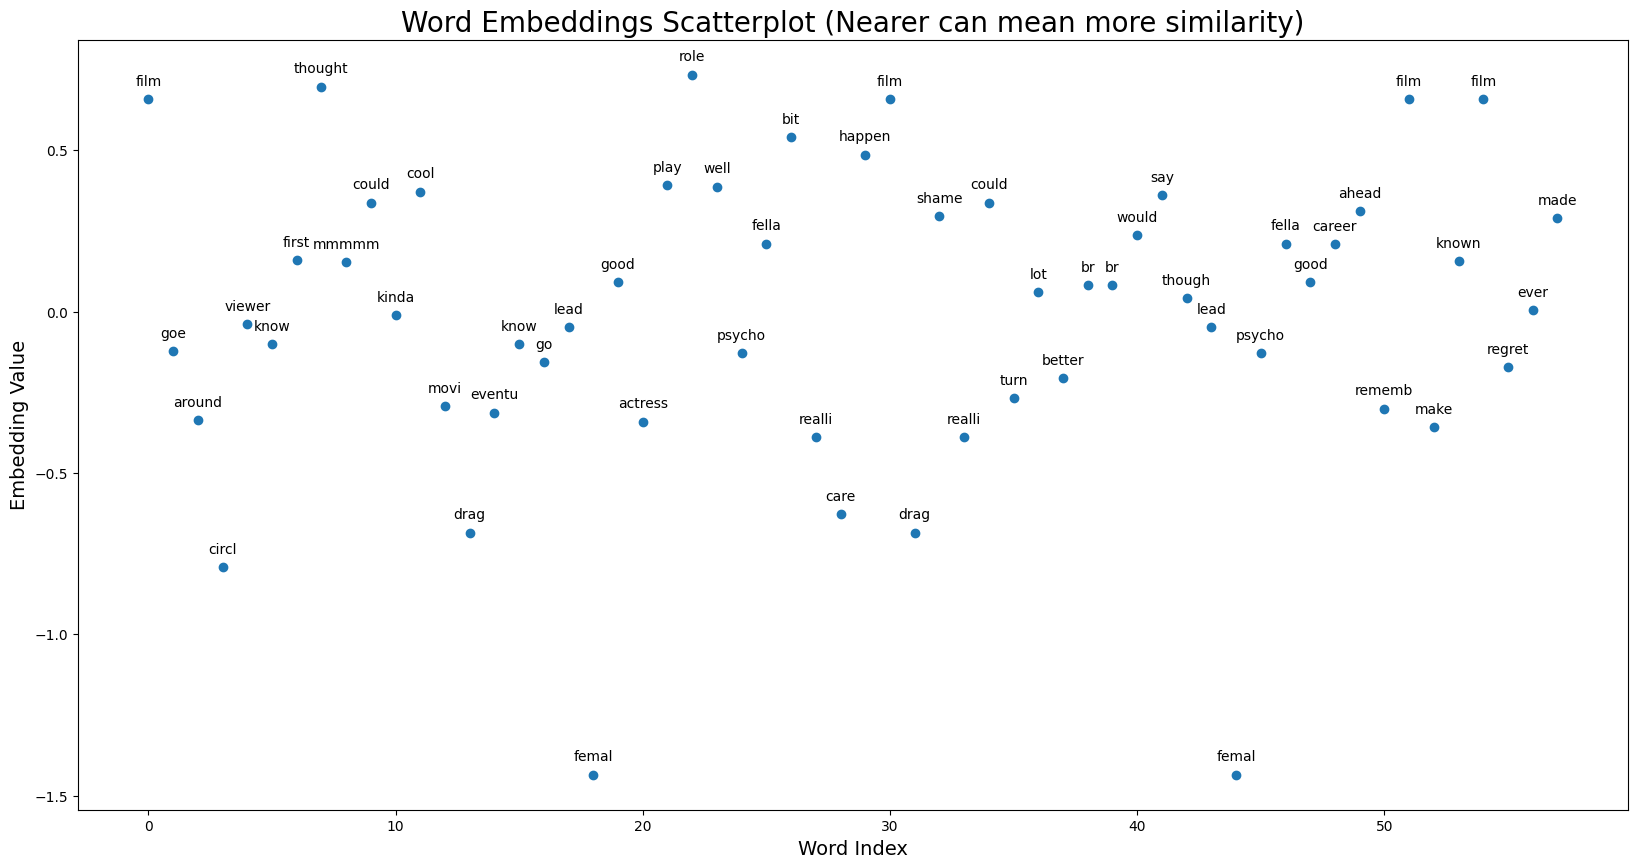

In [140]:
plt.figure(figsize=(20, 10))

df_transposed = df.transpose()
df_transposed.columns = ['embedding']

plt.scatter(range(len(df_transposed)), df_transposed['embedding'])
plt.title('Word Embeddings Scatterplot (Nearer can mean more similarity)', fontsize=20)
plt.xlabel('Word Index', fontsize=14)
plt.ylabel('Embedding Value', fontsize=14)

for i, word in enumerate(df_transposed.index):
    plt.annotate(word, (i, df_transposed['embedding'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

In [141]:
# End the timer to compute notebook execution time.
end_nb = time.time()
nb_exec_time = end_nb - start_nb
print("Notebook execution time (in minutes): ", round((nb_exec_time/60), 0), " minutes", round((nb_exec_time%60), 3), " seconds")

Notebook execution time (in minutes):  20.0  minutes 1.844  seconds


# References
- Demetri Pananos (2016). How can I sample equally from a dataframe? [online] Stack Overflow. Available at: https://stackoverflow.com/questions/40645524/how-can-i-sample-equally-from-a-dataframe [Accessed 21 Nov. 2023].
- Pydata.org. (2023). API reference — pandas 2.1.3 documentation. [online] Available at: https://pandas.pydata.org/docs/reference/index.html#api [Accessed 21 Nov. 2023].
- merchmallow (2021). Sampling from a large dataset. [online] Stack Overflow. Available at: https://stackoverflow.com/questions/67606447/sampling-from-a-large-dataset [Accessed 21 Nov. 2023].
- Stanford.edu. (2022). Splitting into train, dev and test sets. [online] Available at: https://cs230.stanford.edu/blog/split/ [Accessed 21 Nov. 2023].
- scikit-learn. (2016). 3.2. Tuning the hyper-parameters of an estimator. [online] Available at: https://scikit-learn.org/stable/modules/grid_search.html [Accessed 21 Nov. 2023].
- scikit-learn. (2023). API Reference. [online] Available at: https://scikit-learn.org/stable/modules/classes.html [Accessed 21 Nov. 2023].
- Sumeet Kumar Agrawal (2021). Metrics to Evaluate your Classification Model to take the right decisions. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/#:~:text=Common%20metrics%20include%20accuracy%20(proportion,curve%20(AUC%2DROC). [Accessed 21 Nov. 2023].
- "[NLP] Xử lý POS với thuật toán Conditional Random Fields," Trí tuệ nhân tạo, Ngày xuất bản: 23/04/2019, URL: https://trituenhantao.io/kien-thuc/nlp-xu-ly-pos-voi-thuat-toan-conditional-random-fields/, [Accessed 26 Nov. 2023].
- Paperswithcode.com. (2020). Papers with Code - CRF Explained. [online] Available at: https://paperswithcode.com/method/crf [Accessed 26 Nov. 2023].
- Radimrehurek.com. (2022). Gensim: topic modelling for humans. [online] Available at: https://radimrehurek.com/gensim/models/word2vec.html [Accessed 26 Nov. 2023].
- GitHub. (2018). piskvorky/gensim-data: Data repository for pretrained NLP models and NLP corpora. [online] Available at: https://github.com/piskvorky/gensim-data [Accessed 26 Nov. 2023].
- Abad, Alberto; Ortega, Alfonso; Teixeira, António; Mateo, Carmen; Hinarejos, Carlos; Perdigão, Fernando; Batista, Fernando; Mamede, Nuno (2016). Advances in Speech and Language Technologies for Iberian Languages: Third International Conference, IberSPEECH 2016, Lisbon, Portugal, November 23-25, 2016, Proceedings. Cham: Springer. p. 165. ISBN [9783319491691](https://www.google.com/search?q=isbn%3D9783319491691&rlz=1C1GCEA_enVN971VN971&oq=isbn%3D9783319491691&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIKCAEQABiABBiiBDIKCAIQABiABBiiBDIKCAMQABiABBiiBDIKCAQQABiABBiiBDIKCAUQABiABBiiBDIGCAYQRRg80gEHMTcxajBqNKgCALACAA&sourceid=chrome&ie=UTF-8)
- Mikhail Korobov. (2017). [sklearn-crfsuite — sklearn-crfsuite 0.3 documentation](https://sklearn-crfsuite.readthedocs.io/en/latest/). [online] [Accessed 29 Nov. 2023].
- Matplotlib.org. (2023). [API Reference — Matplotlib 3.8.2 documentation](https://matplotlib.org/stable/api/).[online] [Accessed 3 Dec. 2023].